In [1]:
%load_ext autoreload
%autoreload 2

import os
from pathlib import Path
import time
from typing import Tuple, Type

import haiku as hk
import jax
import jax.numpy as jnp
import jraph
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import optax

# Numpyro
import numpyro
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS, init_to_median, Predictive
from numpyro.diagnostics import hpdi

# Local imports
import loss
import dataset_1dgp
import plotting
import model

print(f"JAX version: {jax.__version__}")
print(f"Numpyro version: {numpyro.__version__}")

/Users/salmanfaris/miniforge3/envs/prior-vgae/lib/python3.9/site-packages/jax/_src/lib/__init__.py:34: UserWarning: JAX on Mac ARM machines is experimental and minimally tested. Please see https://github.com/google/jax/issues/5501 in the event of problems.
  warnings.warn("JAX on Mac ARM machines is experimental and minimally tested. "


JAX version: 0.3.13
Numpyro version: 0.9.2


In [2]:
FIG_PATH = Path('./figures/1DGP_figures')
FIG_PATH.mkdir(exist_ok=True)

DATASET_PATH = Path('./dataset.nosync')
DATASET_PATH.mkdir(exist_ok=True)

In [3]:
RNG_SEED = 44
RNG_KEY = jax.random.PRNGKey(RNG_SEED)

# WANT TO TRY DROPOUT LAYER

In [4]:
from dataclasses import dataclass
from typing import Dict, Optional, Callable

LossFun = Callable[[jax.numpy.ndarray, jax.numpy.ndarray], jnp.float32]

@dataclass
class GP1DArgs:
  kernel: Callable = dataset_1dgp.exp_sq_kernel
  num_locations: int = 400
  
@dataclass
class Args:  
  # Training params
  loss_fn: LossFun = loss.compute_mse_loss
  epochs: int = 100_000
  eval_frequency: int = 1000
  learning_rate: float = 1e-3
  beta: float = 1e-2  # beta-VAE
  dropout_rate: float = 0.5
  training: bool = True
  
  # Model params
  hidden_gnn_dim: int = 2
  hidden_fc_dim: int = 60
  latent_dim: int = 30
  output_dim: int = 1
  act_fn: Callable = jax.nn.elu

GP1D_ARGS = GP1DArgs()
ARGS = Args()

In [5]:
model_name = (
    f'PriorVGAE_Dropout_1DGP_lr{ARGS.learning_rate}_epochs{ARGS.epochs}_'
    f'beta{ARGS.beta}_gnn{ARGS.hidden_gnn_dim}_fc{ARGS.hidden_fc_dim}_z{ARGS.latent_dim}_'
    f'numLocations{GP1D_ARGS.num_locations}'
)

model_params_title = (
    '('
    f'epochs = {plotting.convert_to_string_int(ARGS.epochs)}, '
    f'lr = {ARGS.learning_rate}, '
    f'act_fn = {jax.nn.elu.__name__}, '
    rf'$\beta = {ARGS.beta}$, '
    f'\ngnn_dim = {ARGS.hidden_gnn_dim},  fc_dim = {ARGS.hidden_fc_dim},  z_dim = {ARGS.latent_dim}'
    f'\n num_loc = {GP1D_ARGS.num_locations}'
    ')'
)

print(model_name)

PriorVGAE_1DGP_lr0.001_epochs2000000_beta0.01_gnn2_fc60_z30_numLocations400


# Dataset: GP priors to be encoded

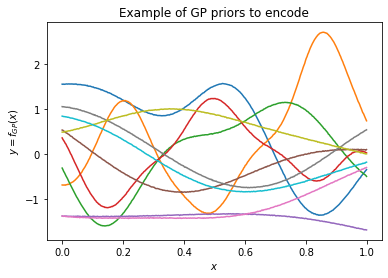

In [6]:
# GP priors to encode
X = jnp.arange(0, 1, 1/GP1D_ARGS.num_locations)

num_to_plot = 10
gp_draws = dataset_1dgp.generate_gp_batch(RNG_KEY, 
                                          X, 
                                          batch_size=num_to_plot,
                                          kernel=GP1D_ARGS.kernel)

plotting.plot_gp_draws(
    X, gp_draws,
    num_draws_to_plot=num_to_plot,
    title='Example of GP priors to encode', 
    x_label='$x$', 
    y_label='$y=f_{GP}(x)$',
)

# Building the model

In [7]:
data_filepath = DATASET_PATH / f'1DGP_numLoc{GP1D_ARGS.num_locations}_1M_train_data.npy'

OVERRIDE_SAVE = False

# Initial RNG_KEY seed is 44.
RNG_KEY, data_rng = jax.random.split(RNG_KEY)
if data_filepath.exists() and not OVERRIDE_SAVE:
    print(f"Loading dataset from {data_filepath}")
    data = np.load(data_filepath)
else:
    num_samples = 1_000_000
    data = dataset_1dgp.generate_gp_batch(data_rng, X, 
                                          batch_size=num_samples, 
                                          kernel=GP1D_ARGS.kernel)
    print(f"Saving dataset to {data_filepath}")
    np.save(data_filepath, np.asarray(data))

Loading dataset from dataset.nosync/1DGP_numLoc400_1M_train_data.npy


In [8]:
# Remove NaNs from dataset
data = data[~np.isnan(data).any(axis=1), :]

train_size_limit = 700_000
val_size = 11_000  # + 1000 for the final epoch evaluation and batching

# train_data = data[:train_size_limit]
train_data = data[:]
val_data = data[train_size_limit:train_size_limit+val_size]

In [9]:
BASE_GRAPH = dataset_1dgp.create_1dgp_graph(GP1D_ARGS.num_locations)

graph_train_data = [BASE_GRAPH._replace(nodes=nodes.reshape(-1, 1)) for nodes in train_data]
graph_val_data = [BASE_GRAPH._replace(nodes=nodes.reshape(-1, 1)) for nodes in val_data]

Comment: Removing linear (hidden_fc) before latent hidden layer makes samples even NOISIER

In [10]:
from functools import partial
from model import VGAEOutput
import layer

class VGAE(hk.Module):
    """VGAE network definition."""

    def __init__(
        self,
        hidden_gnn_dim: int,
        hidden_fc_dim: int,
        latent_dim: int,
        output_dim: int,
        num_nodes: int,
        dropout_rate: float,
    ):
        super().__init__()
        self._hidden_gnn_dim = hidden_gnn_dim
        self._hidden_fc_dim = hidden_fc_dim
        self._latent_dim = latent_dim
        self._output_dim = output_dim
        self._num_nodes = num_nodes
        self._dropout_rate = dropout_rate
        self.act = ARGS.act_fn

    def __call__(self, graph: jraph.GraphsTuple) -> VGAEOutput:
        mean, log_std = encoder(
            graph,
            self._hidden_gnn_dim,
            self._hidden_fc_dim,
            self._latent_dim,
            self._num_nodes,
            self._dropout_rate,
            self.act,
        )

        std = jnp.exp(log_std)
        z = mean + std * jax.random.normal(hk.next_rng_key(), mean.shape)

        output = decoder(
            z,
            self._hidden_fc_dim,
            self._hidden_gnn_dim,
            self._output_dim,
            self._num_nodes,
            self._dropout_rate,
            self.act
        )

        return VGAEOutput(mean, log_std, output)


def encoder(
        graph: jraph.GraphsTuple,
        hidden_gnn_dim: int,
        hidden_fc_dim: int,
        latent_dim: int,
        num_nodes: int,
        dropout_rate: float,
        act_fn: Callable = jax.nn.elu) -> Tuple[jnp.ndarray, jnp.ndarray]:
    
    # Graph layer
    gn = jraph.GraphConvolution(
        update_node_fn=hk.Sequential([
            hk.Linear(hidden_gnn_dim), act_fn,
        ]),
        add_self_edges=True,
    )
    graph = gn(graph)

    graph = layer.GraphwiseLayerNorm()(graph)
    
    x = graph.nodes.reshape(1, num_nodes, hidden_gnn_dim)
    x = hk.Flatten()(x)  # dim: (1, num_nodes*hidden_gnn_dim)

    # I've added another hidden layer
    x = hk.Linear(hidden_fc_dim)(x)
    x = act_fn(x)
    
    if ARGS.training: x = hk.dropout(hk.next_rng_key(), dropout_rate)(x)
    
    x = hk.Linear(hidden_fc_dim)(x)
    x = act_fn(x)
    
    if ARGS.training: x = hk.dropout(hk.next_rng_key(), dropout_rate)(x)
    
    # No activation
    mean = hk.Linear(latent_dim, name='mean')(x)
    log_std = hk.Linear(latent_dim, name='log_std')(x)
    return mean, log_std


def decoder(
        z: jnp.ndarray,
        hidden_fc_dim: int,
        hidden_gnn_dim: int,
        output_dim: int,
        num_nodes: int,
        dropout_rate: float,
        act_fn: Callable = jax.nn.elu) -> jraph.GraphsTuple:
    
    z = hk.Linear(hidden_fc_dim, name='decoder_hidden_fc')(z)
    z = act_fn(z)
    
    if ARGS.training: x = hk.dropout(hk.next_rng_key(), dropout_rate)(x)
    
    z = hk.Linear(hidden_fc_dim, name='decoder_hidden_fc2')(z)
    z = act_fn(z)
    
    if ARGS.training: x = hk.dropout(hk.next_rng_key(), dropout_rate)(x)
    
    z = hk.Linear(num_nodes*hidden_gnn_dim,
                  name='decoder_hidden2_fc')(z)  # (1, num_nodes*hidden_gnn_dim)
    z = act_fn(z)
    
    # Reshape to jraph.batch format: (num_nodes, hidden_gnn_dim)
    z = z.reshape((num_nodes, hidden_gnn_dim))
    graph = BASE_GRAPH._replace(nodes=z)

    gn = layer.GraphConvolutionSharpening(
        update_node_fn=hk.Sequential([
            hk.Linear(hidden_gnn_dim, name='decoder_hidden_gnn'), act_fn,
        ]),
        add_self_edges=True,
    )
    graph = gn(graph)
    
    # # Layer normalization
    # NOTE :- Layer normalization on the decoder yields a shrinked GP.
    # graph = layer.GraphwiseLayerNorm()(graph)
    
    # No activation
    gn = layer.GraphConvolutionSharpening(
        update_node_fn=hk.Linear(output_dim, name='decoder_output'),
        add_self_edges=False,
    )
    graph = gn(graph)


    return graph

In [11]:
extend_model_params_title = True
    
extension_string = 'using_GAT = False, add_self_edges = True, dropout = True'

if extend_model_params_title:
    model_params_title = model_params_title[:-1] + ', ' + extension_string

# Training time

In [12]:
# Initialize network and optimizer.
net = hk.transform(
  lambda x: VGAE(hidden_gnn_dim=ARGS.hidden_gnn_dim,
                 hidden_fc_dim=ARGS.hidden_fc_dim,
                 latent_dim=ARGS.latent_dim, 
                 output_dim=ARGS.output_dim,
                 dropout_rate=ARGS.dropout_rate,
                 num_nodes=GP1D_ARGS.num_locations)(x))

## Training optimizer

In [13]:
# optimizer = optax.adam(ARGS.learning_rate)

scheduler = optax.exponential_decay(
    init_value=ARGS.learning_rate,
    transition_steps=2000,
    decay_rate=0.99,
)

# Combining gradient transforms using `optax.chain`
optimizer = optax.chain(
    optax.clip_by_global_norm(1.0),  # Clip by the gradient by the global norm.
    optax.scale_by_adam(),  # Use the updates from adam.
    optax.scale_by_schedule(scheduler),  # Use the learning rate from the scheduler.
    # Scale updates by -1 since optax.apply_updates is additive and we want to descend on the loss.
    optax.scale(-1.0)
)

### Loss function and update

In [14]:
@jax.jit
def loss_fn(
    params: hk.Params, 
    rng_key: jnp.ndarray,
    graph: jraph.GraphsTuple,
) -> jnp.ndarray:
  """Computes VGAE loss."""
  log_likelihood_loss_fn = ARGS.loss_fn
  
  outputs: VGAEOutput = net.apply(params, rng_key, graph)
  log_likelihood = -log_likelihood_loss_fn(outputs.output.nodes, graph.nodes)
  kld = jnp.mean(loss.compute_kl_gaussian(outputs.mean, outputs.log_std), axis=-1)
  elbo = (1.0/ARGS.beta)*log_likelihood - kld
  
  return -elbo, kld
  
@jax.jit
def update(
    params: hk.Params,
    rng_key: jnp.ndarray,
    opt_state: optax.OptState,
    graph: jraph.GraphsTuple,
):
  """Updates the parameters of the network."""
  grads, _ = jax.grad(loss_fn, has_aux=True)(params, rng_key, graph)
  updates, new_opt_state = optimizer.update(grads, opt_state)
  new_params = optax.apply_updates(params, updates)
  return new_params, new_opt_state

### Initialize net and optimizer

In [15]:
# Initialize net with an arbitrary graph
RNG_KEY, params_rng = jax.random.split(RNG_KEY)

init_graph = graph_train_data[0]
params = net.init(params_rng, init_graph)
opt_state = optimizer.init(params)

In [16]:
RNG_KEY, train_rng = jax.random.split(RNG_KEY)

train_losses = []
val_losses = []
train_klds = []
val_klds = []

train_size = len(graph_train_data)
val_size = len(graph_val_data)

eval_counter: int = 0

training_start_time = time.time()
print('using: ', ARGS.loss_fn)
for epoch in range(ARGS.epochs):
  update_rng = jax.random.fold_in(train_rng, epoch)

  train_graph_batch = graph_train_data[epoch % train_size]
  params, opt_state = update(params, update_rng, opt_state, train_graph_batch)
    
  if epoch % ARGS.eval_frequency == 0 or epoch == (ARGS.epochs - 1):
    evaluate_rng = jax.random.fold_in(update_rng, epoch)
    train_loss_rng, eval_loss_rng = jax.random.split(evaluate_rng)
    
    train_loss, train_kld = loss_fn(params, train_loss_rng, train_graph_batch)
    
    val_graph_batch = graph_val_data[eval_counter]
    val_loss, val_kld = loss_fn(params, eval_loss_rng, val_graph_batch)
    
    print(f'{time.strftime("%H:%M:%S", time.localtime())} STEP: {epoch}; '
          f'Train loss: {train_loss:.3f}; Validation loss: {val_loss:.3f}; '
          # f'Train kld: {train_kld:.3f}; Validation kld: {val_kld:.3f}'
    )
      
    train_losses.append(train_loss.item())
    val_losses.append(val_loss.item())
    train_klds.append(train_kld.item())
    val_klds.append(val_kld.item())
    
    eval_counter += 1

training_end_time = time.time() - training_start_time
print(f'Training took: ({training_end_time:.3f} secs; equivalently {training_end_time/60:.3f} mins)')

using:  <function compute_mse_loss at 0x152f710d0>
21:38:38 STEP: 0; Train loss: 93.888; Validation loss: 170.666; 
21:38:39 STEP: 1000; Train loss: 48.347; Validation loss: 17.130; 
21:38:39 STEP: 2000; Train loss: 21.711; Validation loss: 69.372; 
21:38:40 STEP: 3000; Train loss: 21.397; Validation loss: 18.541; 
21:38:40 STEP: 4000; Train loss: 36.868; Validation loss: 30.913; 
21:38:41 STEP: 5000; Train loss: 27.201; Validation loss: 100.169; 
21:38:41 STEP: 6000; Train loss: 15.015; Validation loss: 83.704; 
21:38:42 STEP: 7000; Train loss: 12.687; Validation loss: 77.305; 
21:38:42 STEP: 8000; Train loss: 54.072; Validation loss: 76.795; 
21:38:43 STEP: 9000; Train loss: 10.597; Validation loss: 13.509; 
21:38:43 STEP: 10000; Train loss: 33.042; Validation loss: 26.142; 
21:38:44 STEP: 11000; Train loss: 14.301; Validation loss: 15.601; 
21:38:45 STEP: 12000; Train loss: 11.757; Validation loss: 28.899; 
21:38:45 STEP: 13000; Train loss: 9.229; Validation loss: 16.899; 
21:38:46 

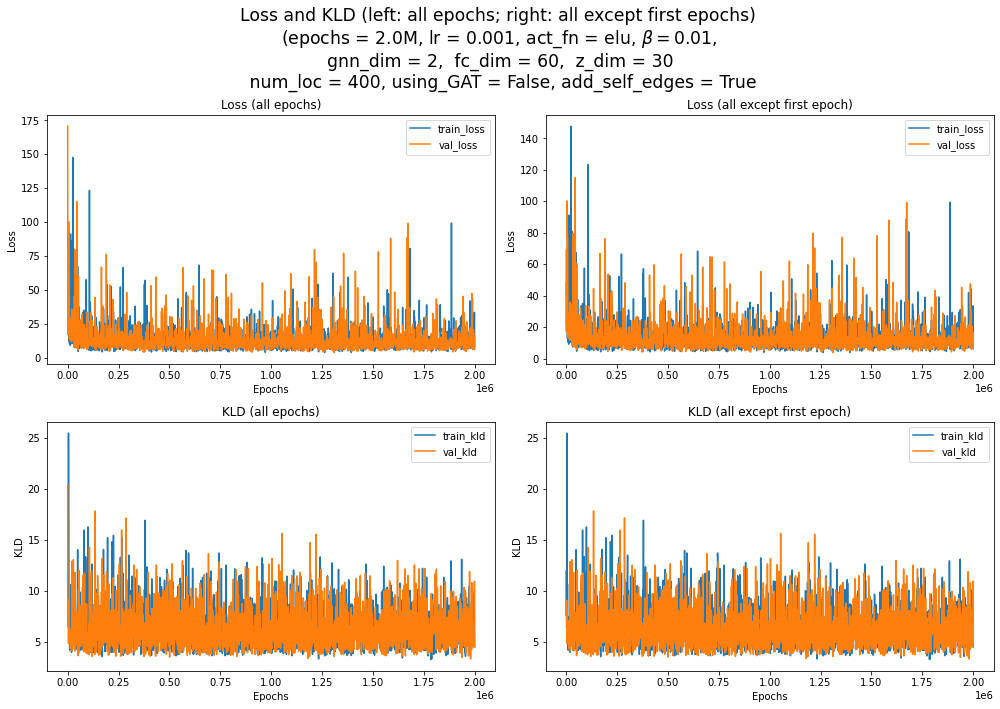

In [17]:
from matplotlib.ticker import MaxNLocator

# Loss plots
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# for i in range(2): axes[i].xaxis.set_major_locator(MaxNLocator(integer=True))

xs = np.arange(len(train_losses))*ARGS.eval_frequency
axes[0, 0].plot(xs, train_losses, label='train_loss')
axes[0, 0].plot(xs, val_losses, label='val_loss')
axes[0, 1].plot(xs[1:], train_losses[1:], label='train_loss')
axes[0, 1].plot(xs[1:], val_losses[1:], label='val_loss')
axes[0, 0].set_title('Loss (all epochs)')
axes[0, 1].set_title('Loss (all except first epoch)')

for i in range(2): 
    axes[0, i].set_ylabel('Loss')
    axes[0, i].set_xlabel('Epochs')
    axes[0, i].legend()
    
# KLD plots
xs = np.arange(len(train_klds))*ARGS.eval_frequency
axes[1, 0].plot(xs, train_klds, label='train_kld')
axes[1, 0].plot(xs, val_klds, label='val_kld')
axes[1, 1].plot(xs[1:], train_klds[1:], label='train_kld')
axes[1, 1].plot(xs[1:], val_klds[1:], label='val_kld')
axes[1, 0].set_title('KLD (all epochs)')
axes[1, 1].set_title('KLD (all except first epoch)')

for i in range(2): 
    axes[1, i].set_ylabel('KLD')
    axes[1, i].set_xlabel('Epochs')
    axes[1, i].legend()

fig.suptitle(f'Loss and KLD (left: all epochs; right: all except first epochs) \n{model_params_title}', fontsize='xx-large')

plt.tight_layout()
plt.show()

loss_kld_path = FIG_PATH / 'loss_kld_figures'
loss_kld_path.mkdir(exist_ok=True)
fig.savefig(loss_kld_path / f'{model_name}.jpg', dpi=300)

In [ ]:
# Switch off dropout
ARGS.training = False

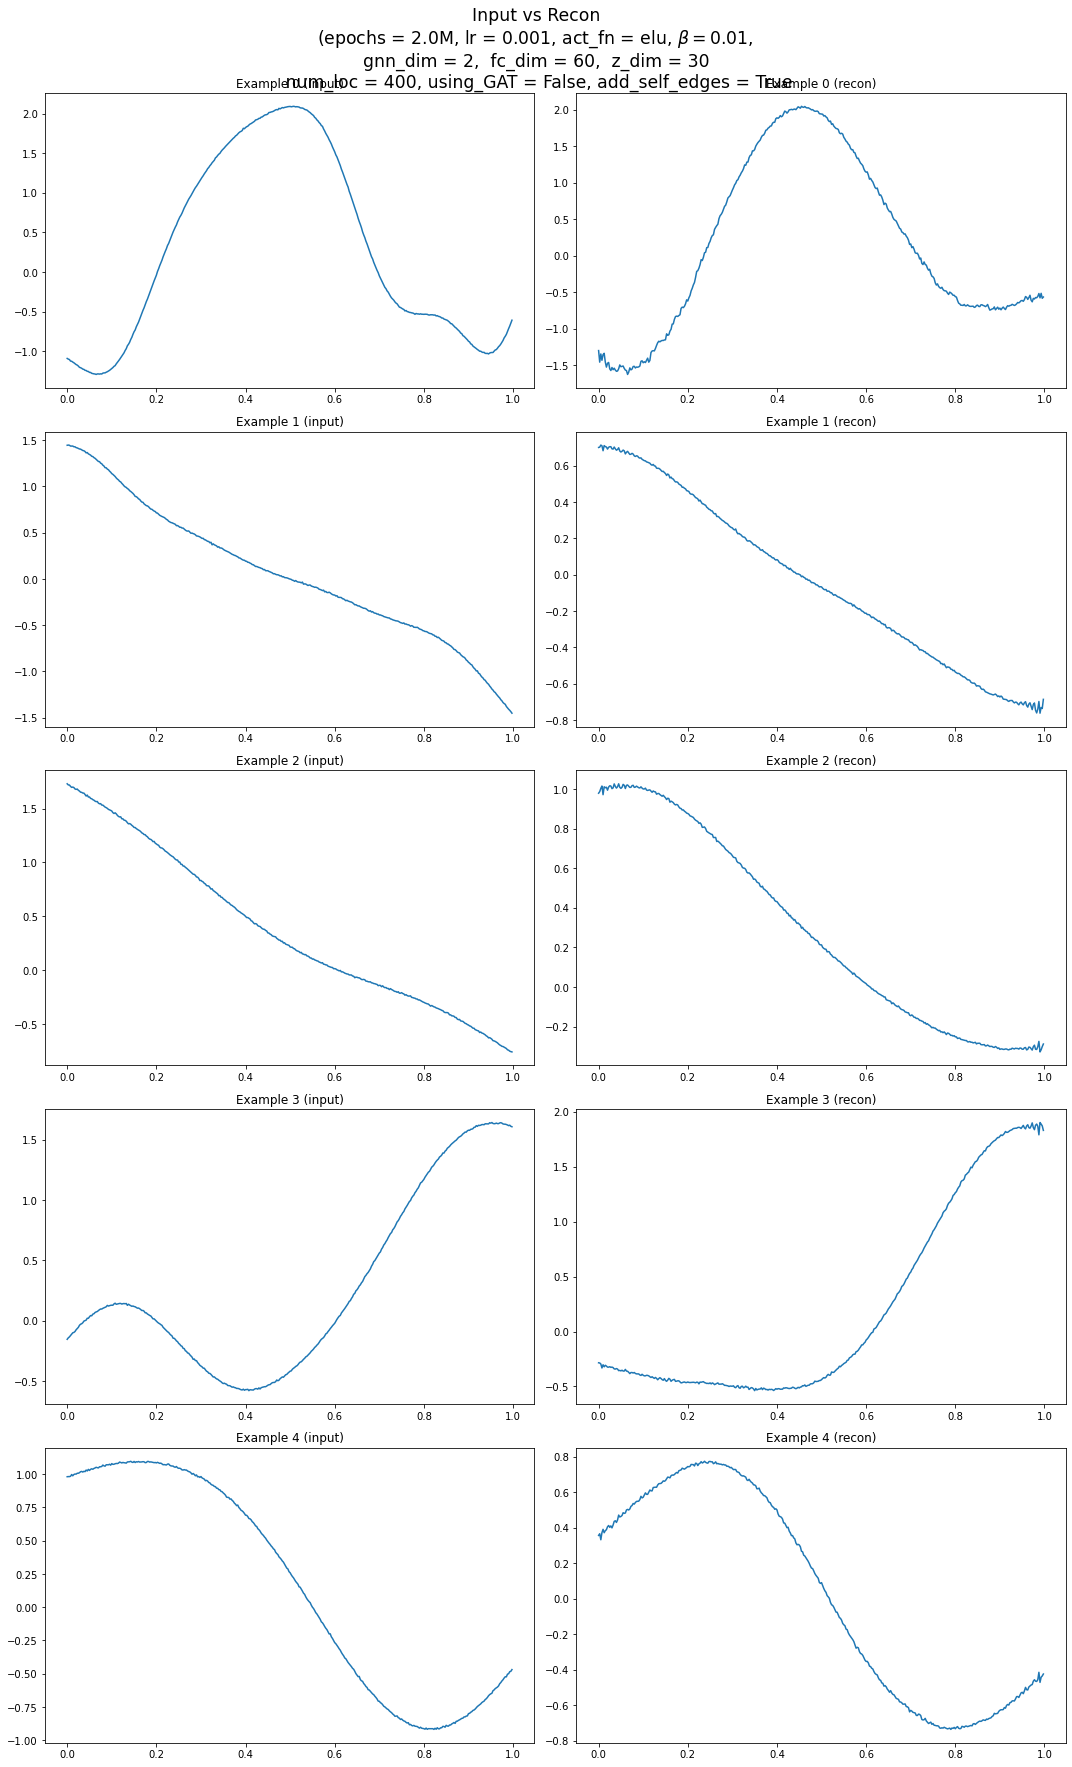

In [18]:
RNG_KEY, rng_recon = jax.random.split(RNG_KEY)

num_to_plot = 5
fig, axes = plt.subplots(num_to_plot, 2, figsize=(15, 25))

for i in range(num_to_plot):
    original_data = val_data[i]
    graph_data = graph_val_data[i]
    
    outputs = net.apply(params, RNG_KEY, graph_data)
    recon_data = outputs.output.nodes.T

    original_gp = jnp.ravel(original_data)
    recon_gp = jnp.ravel(recon_data)

    axes[i, 0].plot(X, original_gp)
    axes[i, 1].plot(X, recon_gp)
    
    axes[i, 0].set_title(f'Example {i} (input)')
    axes[i, 1].set_title(f'Example {i} (recon)')

fig.suptitle(f'Input vs Recon\n{model_params_title}', fontsize='xx-large')

plt.tight_layout()
plt.show()

input_v_recon_path = FIG_PATH / 'recon_figures'
input_v_recon_path.mkdir(exist_ok=True)
fig.savefig(input_v_recon_path / f'{model_name}.jpg', dpi=300)

In [19]:
from functools import partial

decoder_params_keys = [k for k in list(params.keys()) if k.startswith('vgae/decoder')]
decoder_params = {}
for full_key_name in decoder_params_keys:
    key_name = full_key_name.split('/')[-1]  # remove the 'vgae/' prefix
    decoder_params[key_name] = params[full_key_name]
    
GP1D_ARGS.decoder_params = decoder_params

decoder_net_fn = partial(decoder,
                         hidden_fc_dim=ARGS.hidden_fc_dim,
                         hidden_gnn_dim=ARGS.hidden_gnn_dim,
                         output_dim=ARGS.output_dim,
                         dropout_rate=ARGS.dropout_rate,
                         num_nodes=GP1D_ARGS.num_locations)
decoder_net = hk.without_apply_rng(hk.transform(decoder_net_fn))

In [20]:
def decoder_predictive_model():
    z = numpyro.sample('z', dist.Normal(0, 1).expand([ARGS.latent_dim]))
    vgae_out = jnp.squeeze(decoder_net.apply(GP1D_ARGS.decoder_params, z).nodes)
    numpyro.deterministic('f', vgae_out)

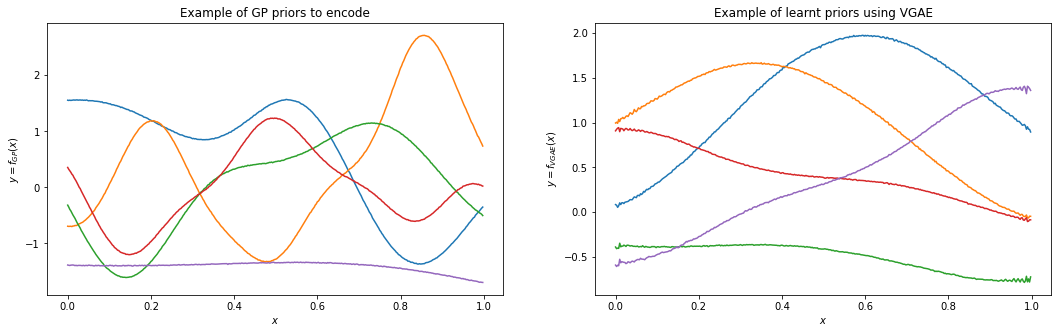

In [21]:
# Rough comparison of the shape of GP draws with learnt VGAE priors.

# Drawing VGAE priors.
RNG_KEY, vgae_sample_rng = jax.random.split(RNG_KEY)
vgae_draws = Predictive(
  decoder_predictive_model, num_samples=10)(vgae_sample_rng)['f']

# Plotting the GP draws and VGAE draws.
_, ax = plt.subplots(1, 2, figsize=(18, 5))

plotting.plot_gp_draws(X, gp_draws, num_draws_to_plot=5, 
                     ax=ax[0], title='Example of GP priors to encode', y_label='$y=f_{GP}(x)$')

plotting.plot_gp_draws(X, vgae_draws, num_draws_to_plot=5, 
                     ax=ax[1], title='Example of learnt priors using VGAE', y_label='$y=f_{VGAE}(x)$', )

plt.show()

In [22]:
# Comparing distribution of GP draws with learnt VGAE priors.
RNG_KEY, gp_rng, vgae_rng = jax.random.split(RNG_KEY, 3)

num_samples = 1000
gp_draws = dataset_1dgp.generate_gp_batch(gp_rng, X, 
                                          batch_size=num_samples, 
                                          kernel=GP1D_ARGS.kernel)
vgae_draws = Predictive(decoder_predictive_model, num_samples=num_samples)(vgae_rng)['f']

# Computing the mean and HPDI of the GP draws and VGAE draws.
gp_draws = gp_draws[~np.isnan(gp_draws).any(axis=1), :]
mean_gp = jnp.nanmean(gp_draws, axis=0)
hpdi_gp = hpdi(gp_draws, 0.9)

vgae_draws = vgae_draws[~np.isnan(vgae_draws).any(axis=1), :]
mean_vgae = jnp.nanmean(vgae_draws, axis=0)
hpdi_vgae = hpdi(vgae_draws, 0.9)

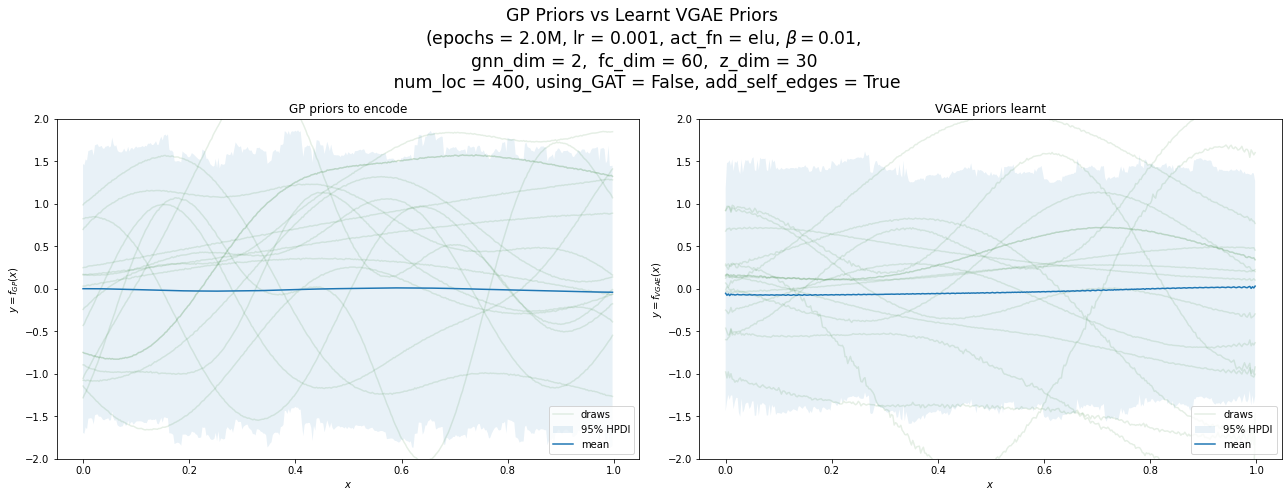

In [23]:

# Plotting the GP draws and VGAE draws.
fig, axes = plt.subplots(1, 2, figsize=(18, 7))

y_lim = [-2, 2]
lines_alpha_gp = 0.1
lines_alpha_vgae = 0.1
num_draws_to_plot = 15
plotting.plot_gp_draws_with_stats(
    X, gp_draws, 
    mean_gp, hpdi_gp,lines_alpha_gp, 
    num_draws_to_plot, y_lim=y_lim, ax=axes[0],
    title='GP priors to encode', y_label='$y=f_{GP}(x)$')
plotting.plot_gp_draws_with_stats(
    X, vgae_draws, mean_vgae, hpdi_vgae,
    lines_alpha_vgae, num_draws_to_plot, 
    y_lim=y_lim, ax=axes[1],
    title='VGAE priors learnt',
    y_label='$y=f_{VGAE}(x)$')

fig.suptitle(f'GP Priors vs Learnt VGAE Priors \n{model_params_title}', fontsize='xx-large')

plt.tight_layout()
plt.show()

estimate_plot_path = FIG_PATH / 'estimate_figures'
estimate_plot_path.mkdir(exist_ok=True)
fig.savefig(estimate_plot_path / f'{model_name}.jpg', dpi=300)

In [24]:
assert False, 'Inference is turned off'

AssertionError: Inference is turned off

# Inference on Observed Data

In [ ]:
def vgae_mcmc_predictive_model(y=None, obs_idx=None):
    z = numpyro.sample('z', dist.Normal(0, 1).expand([ARGS.latent_dim]))
    vgae_out = jnp.squeeze(decoder_net.apply(decoder_params, z).nodes)
    f = numpyro.deterministic('f', vgae_out)
    sigma = numpyro.sample('noise', dist.HalfNormal(0.1))

    if y is None: # at prediction time
        numpyro.sample('y_pred', dist.Normal(f, sigma))
    else: # at inference time
        numpyro.sample('y', dist.Normal(f[obs_idx], sigma), obs=y)

In [ ]:
def run_mcmc(rng, model_mcmc, y, obs_idx, verbose=False):
    start = time.time()
    init_strategy = init_to_median(num_samples=10)
    kernel = NUTS(model_mcmc, init_strategy=init_strategy)
    mcmc = MCMC(
        kernel,
        num_warmup=1000,
        num_samples=1000,
        num_chains=4,
        thinning=1,
        progress_bar=False if 'NUMPYRO_SPHINXBUILD' in os.environ else True,
    )
    mcmc.run(rng, y, obs_idx)
    if verbose:
        mcmc.print_summary(exclude_deterministic=False)
    print('\nMCMC elapsed time:', time.time() - start)

    return mcmc.get_samples()

In [ ]:
RNG_KEY, gp_rng = jax.random.split(RNG_KEY)

# Generate true data and observed dataset to infer
draws = Predictive(dataset_1dgp.gp_predictive_model, num_samples=1)(
  gp_rng, x=X, gp_kernel=GP1D_ARGS.kernel, noise=True)
gp_draw = draws['f'].T  # True data
y_draw = draws['y'].T  # True data + noise

# Choose indices of datapoints for inference.
obs_locations = [
  jnp.array([122, 321]),  # 2 observed datapoints
  jnp.array([126, 133, 296, 370]),  # 4 observed datapoints
  jnp.array([71, 85, 111, 291, 314, 380]),  # 6 observed datapoints
]

In [ ]:
mean_post_preds_list = []
hpdi_post_preds_list = []
obs_xs = []
obs_ys = []
predictions_list = []

RNG_KEY, inference_rng = jax.random.split(RNG_KEY)

for i, obs_location in enumerate(obs_locations):
    mcmc_rng, pred_rng = jax.random.split(jax.random.fold_in(inference_rng, i), 2)
    
    x_obs = X[obs_location]
    y_obs = jnp.squeeze(y_draw[obs_location])
    
    print(f'Running chain for n_obs = {len(obs_location)}')
    mcmc_samples = run_mcmc(mcmc_rng, vgae_mcmc_predictive_model, y_obs, obs_location)

    predictions = Predictive(vgae_mcmc_predictive_model, mcmc_samples)(pred_rng)['f']
    mean_post_pred = jnp.mean(predictions, axis=0)
    hpdi_post_pred = hpdi(predictions, 0.9)
    
    obs_xs.append(x_obs)
    obs_ys.append(y_obs)
    predictions_list.append(predictions)
    mean_post_preds_list.append(mean_post_pred)
    hpdi_post_preds_list.append(hpdi_post_pred)

Running chain for n_obs = 2


/var/folders/6h/lf5jg1fn1h163zw3042tmtnc0000gn/T/ipykernel_5109/3494085863.py:5: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(
sample: 100%|██████████| 2000/2000 [00:04<00:00, 487.64it/s, 63 steps of size 8.19e-02. acc. prob=0.90]



MCMC elapsed time: 19.02061104774475


/var/folders/6h/lf5jg1fn1h163zw3042tmtnc0000gn/T/ipykernel_5109/3494085863.py:5: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(


Running chain for n_obs = 4


sample: 100%|██████████| 2000/2000 [00:02<00:00, 726.34it/s, 15 steps of size 1.87e-01. acc. prob=0.85]



MCMC elapsed time: 13.353949069976807


/var/folders/6h/lf5jg1fn1h163zw3042tmtnc0000gn/T/ipykernel_5109/3494085863.py:5: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(


Running chain for n_obs = 6


sample: 100%|██████████| 2000/2000 [00:02<00:00, 858.88it/s, 15 steps of size 2.24e-01. acc. prob=0.91] 



MCMC elapsed time: 12.236498355865479


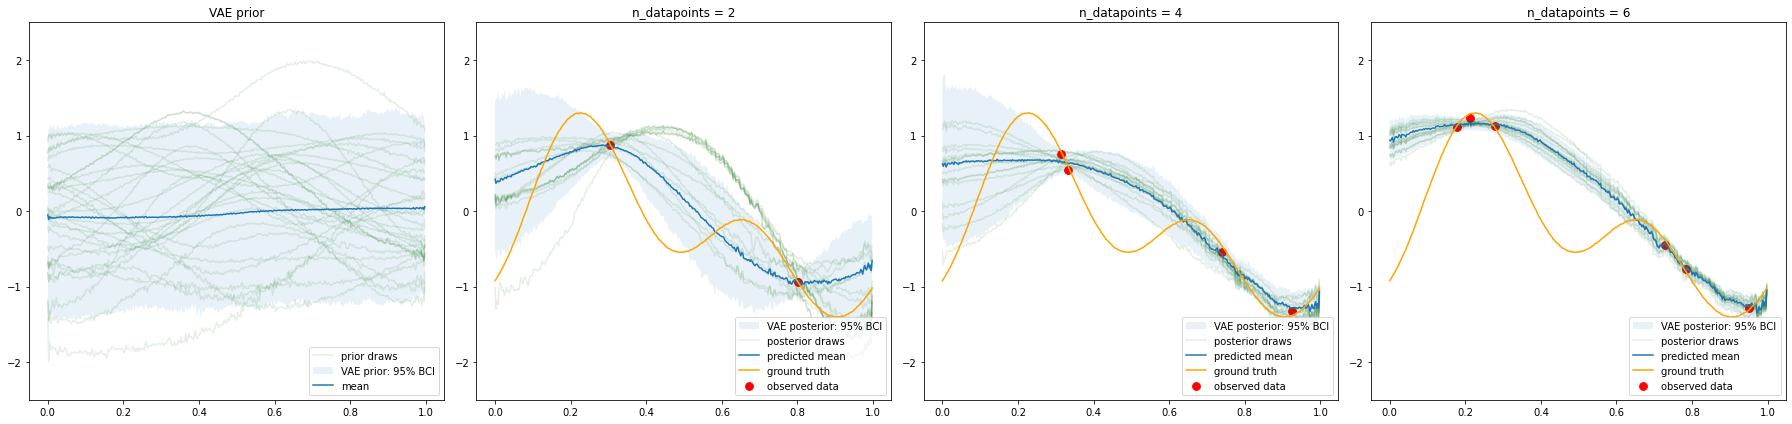

In [ ]:
# Plotting results after inference using MCMC.
_, axes = plt.subplots(nrows=1, ncols=len(obs_locations)+1, figsize=(25,6))

# Plotting VAE prior predictive.
RNG_KEY, prior_rng = jax.random.split(RNG_KEY)
prior_predictions = Predictive(vgae_mcmc_predictive_model, num_samples=10000)(prior_rng)['f']
mean_prior_pred = jnp.mean(prior_predictions, axis=0)
hpdi_prior_pred = hpdi(prior_predictions, 0.9)

num_draws_to_plot = 30
for j in range(num_draws_to_plot):
    axes[0].plot(X, prior_predictions[j], alpha=0.1, color='darkgreen')
axes[0].plot(X, prior_predictions[0], 
             alpha=0.1, color='darkgreen', label='prior draws')  
axes[0].fill_between(X, hpdi_prior_pred[0], hpdi_prior_pred[1], 
                     alpha=0.1, interpolate=True, label='VAE prior: 95% BCI')
axes[0].plot(X, mean_prior_pred, label='mean')
axes[0].set_title('VAE prior')


# Plotting VAE posterior predictive
num_draws_to_plot = 15
for idx in range(len(obs_locations)):
    axes[idx+1].fill_between(X, hpdi_post_preds_list[idx][0], hpdi_post_preds_list[idx][1], 
                           alpha=0.1, interpolate=True, label='VAE posterior: 95% BCI')
    for j in range(num_draws_to_plot): 
        axes[idx+1].plot(X, predictions_list[idx][j], alpha=0.1, color='darkgreen')
    axes[idx+1].plot(X, predictions_list[idx][0],
                   alpha=0.1, color='darkgreen', label='posterior draws')  
    axes[idx+1].plot(X, mean_post_preds_list[idx], label='predicted mean')
    axes[idx+1].plot(X, gp_draw, label='ground truth', color='orange')
    axes[idx+1].scatter(obs_xs[idx], obs_ys[idx], color='red', label='observed data', s=60)
    axes[idx+1].set_title('n_datapoints = ' + str(len(obs_locations[idx])))


for i in range(len(obs_locations)+1):    
    axes[i].legend(loc=4)
    axes[i].set_ylim([-2.5, 2.5])

plt.tight_layout()
plt.show()